In [6]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ibmqfactory.load_account:WARNING:2022-04-09 01:37:41,080: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/home/djanloo/.virtualenvs/valerio_amico_quantum_00-26iBho32/lib/python3.9/site-packages/qiskit/utils/mitigation/fitters.py'

In [8]:
n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                     0,                     0,                     0,                     0,                     0,                     0,   0],
[  0,       1.0 + 0.00395*I,  0.000758 + 0.00395*I,                     0, -0.000711 - 0.00791*I,                     0,                     0,   0],
[  0, -0.000711 + 0.00395*I,       1.0 - 0.00791*I,                     0,  0.000758 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,       1.0 + 0.00395*I,                     0, -0.000711 + 0.00395*I,  0.000758 - 0.00791*I,   0],
[  0,  0.000758 - 0.00791*I, -0.000711 + 0.00395*I,                     0,       1.0 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,  0.000758 + 0.00395*I,                     0,       1.0 - 0.00791*I, -0.000711 + 0.00395*I,   0],
[  0,                     0,                     0, -0.000711 - 0.00791*I,                 

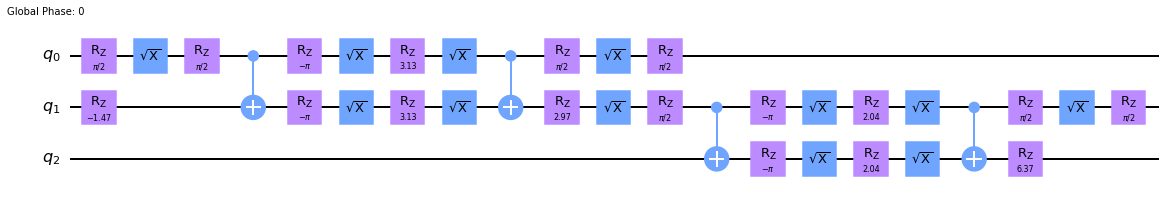

In [9]:
# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [10]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[0.9999921798 - 0.0039547854*I,                             0,                              0,                             0,                              0,                              0,                              0,                             0],
[                            0, 0.9999525415 - 0.0039546286*I, -0.0008497033 + 0.0088630496*I,                             0,                              0,                              0,                              0,                             0],
[                            0, 0.0007108045 + 0.0039546286*I,  0.4498730502 - 0.0353008317*I,                             0, -0.8923785578 + 0.0035291933*I,                              0,                              0,                             0],
[                            0,                             0,                              0, 0.4498908833 - 0.0353022311*I,                              0, -0.8923431852 + 0.0035290534*I,   0.000758263 - 0.0079092573*I,        

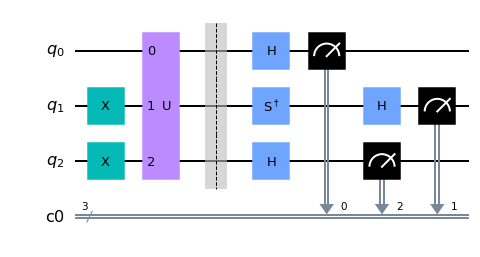

In [11]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [12]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [13]:
cal_circ[0].draw()

░ ┌─┐      
q27_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q27_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q27_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [14]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [15]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [16]:
calib_circuits_identity[1].draw()

┌────┐┌───┐   ┌─┐
q31_0: ┤0   ├┤ X ├───┤M├
       │    │└┬─┬┘   └╥┘
q31_1: ┤1 U ├─┤M├─────╫─
       │    │ └╥┘ ┌─┐ ║ 
q31_2: ┤2   ├──╫──┤M├─╫─
       └────┘  ║  └╥┘ ║ 
 c5: 3/════════╩═══╩══╩═
               1   2  0

In [17]:
calib_circuits_itself[1].draw()

┌───┐┌────┐┌─┐      
q30_0: ┤ X ├┤0   ├┤M├──────
       └───┘│    │└╥┘┌─┐   
q30_1: ─────┤1 U ├─╫─┤M├───
            │    │ ║ └╥┘┌─┐
q30_2: ─────┤2   ├─╫──╫─┤M├
            └────┘ ║  ║ └╥┘
 c4: 3/════════════╩══╩══╩═
                   0  1  2

In [35]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [36]:
qiskit_raw_cal = deepcopy(job_cal_qiskit.result().get_counts())

# Mitigation:

    - building the calibration matrices

In [37]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [38]:
new_counts_qiskit = []
for counts in job_cal_qiskit.result().get_counts():
    new_counts_qiskit.append(meas_fitter_qiskit.filter.apply(counts, method="least_squares"))

In [39]:
migigated_qiskit = occurrences_to_matrix(new_counts_qiskit)
Matrix(migigated_qiskit)

Matrix([
[                1.0, 7.41153828847513e-25,   0,                    0,   0,  2.90719424069115e-9,                    0,                    0],
[                  0,                  1.0,   0,                    0,   0,  1.6272415149024e-10,   8.470329472543e-25,                    0],
[6.7762635780344e-24,  5.0821976835258e-24, 1.0, 1.27054942088145e-24,   0,  3.10857995930187e-9,                    0,                    0],
[                  0,                    0,   0,                  1.0,   0,   2.9790245648989e-9,  4.2351647362715e-24, 1.67056034376351e-17],
[                  0,                    0,   0,                    0, 1.0, 7.02979043263339e-11,                    0,  4.2351647362715e-25],
[                  0, 6.04307418823169e-18,   0,                    0,   0,     0.99999998656978,                    0,                    0],
[                  0,  1.6940658945086e-24,   0,                    0,   0,  2.96599429428206e-9,                  1.0,              

In [43]:
not_migigated_qiskit = occurrences_to_matrix(qiskit_raw_cal)
Matrix(not_migigated_qiskit).n(2, chop=True)

Matrix([
[  0.95,   0.046,   0.035,  0.0019,   0.042, 0.0018,  0.0012,      0],
[ 0.017,    0.92, 0.00059,   0.033, 0.00069,  0.039,       0, 0.0016],
[0.0078, 0.00056,    0.92,   0.048,       0,      0,    0.04, 0.0021],
[     0,  0.0075,   0.016,    0.89,       0,      0, 0.00069,  0.041],
[ 0.023,  0.0016, 0.00075,       0,    0.93,  0.048,   0.033, 0.0017],
[     0,   0.023,       0, 0.00097,   0.016,    0.9, 0.00062,  0.033],
[     0,       0,   0.024,  0.0012,   0.008, 0.0005,    0.91,  0.047],
[     0,       0,       0,   0.023,       0, 0.0072,   0.014,   0.87]])

In [45]:
calib = np.linalg.multi_dot([migigated_qiskit, np.linalg.inv(not_migigated_qiskit)])
Matrix(calib).n(2, chop=True)

Matrix([
[   1.1,  -0.053,   -0.04,  0.0019,  -0.047,  0.0027,  0.0021,      0],
[-0.019,     1.1, 0.00072,   -0.04, 0.00084,  -0.047,       0, 0.0016],
[-0.009,       0,     1.1,  -0.058,       0,       0,  -0.048, 0.0027],
[     0, -0.0091,   -0.02,     1.1,       0,       0, 0.00086, -0.052],
[-0.026, 0.00087,  0.0011,       0,     1.1,  -0.057,  -0.039, 0.0021],
[     0,  -0.028,       0, 0.00089,  -0.019,     1.1, 0.00058, -0.042],
[     0,       0,  -0.029,  0.0016, -0.0095,       0,     1.1, -0.059],
[     0,       0,       0,   -0.03,       0, -0.0092,  -0.018,    1.1]])

In [47]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [50]:
27*8+8

224

In [49]:
Matrix(np.linalg.inv(
    
)).n(2, chop=True)

Matrix([
[   1.1,  -0.053,   -0.04,  0.0019,  -0.047,  0.0027,  0.0021,      0],
[-0.019,     1.1, 0.00072,   -0.04, 0.00084,  -0.047,       0, 0.0016],
[-0.009,       0,     1.1,  -0.058,       0,       0,  -0.048, 0.0027],
[     0, -0.0091,   -0.02,     1.1,       0,       0, 0.00086, -0.052],
[-0.026, 0.00087,  0.0011,       0,     1.1,  -0.057,  -0.039, 0.0021],
[     0,  -0.028,       0, 0.00089,  -0.019,     1.1, 0.00058, -0.042],
[     0,       0,  -0.029,  0.0016, -0.0095,       0,     1.1, -0.059],
[     0,       0,       0,   -0.03,       0, -0.0092,  -0.018,    1.1]])

In [40]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [41]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q1476_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q1476_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q1476_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c19: 3/══════╩════════════════╩══╩═
               1                0  2

In [25]:
C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [31]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [32]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [33]:
raw_res.get_counts(-1)

{'011': 115,
 '111': 943,
 '001': 11,
 '110': 27808,
 '100': 1318,
 '101': 72,
 '000': 147,
 '010': 1586}

In [34]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit


In [32]:
len(qiskit_res.get_counts())

27

In [ ]:
for i in range(27):

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [ ]:
itself_res.get_counts(-1)

{'000': 6.557077361006407e-10,
 '100': 1.811984311076223e-09,
 '101': 1.8407541674736114e-10,
 '110': 31999.999999997523,
 '111': 9.072510385099361e-10}

In [ ]:
identity_res.get_counts(-1)

{'000': 2.6074544486914264e-11,
 '001': 4.30767029067845e-13,
 '010': 128.87302609069673,
 '011': 8.82842606388628,
 '100': 23.089527588879186,
 '101': 6.277067632292315e-12,
 '110': 31839.20902025649,
 '111': 2.7422348485663702e-11}

In [ ]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.87096323, 0.95870307, 0.99668004, 0.98241746])